<!--NOTEBOOK_HEADER-->
*This notebook contains material from the [ND-Pyomo-Cookbook](https://jckantor.github.io/ND-Pyomo-Cookbook) by
Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/ND-Pyomo-Cookbook.git).
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

# S09 - Modèles de production avec contraintes linéaires
Ce notebook démontre l'utilisation de la programmation linéaire pour maximiser les profits pour un modèle simple d'une installation de production multi-produits. Ce Jupyter Notebook utilise [Pyomo](http://www.pyomo.org/) pour représenter le modèle avec le solveur [GLPK](https://www.gnu.org/software/glpk/) pour calculer les solutions.

## Importations

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    if "google.colab" in sys.modules:
        !pip install -q pyomo
    else:
        !conda install -c conda-forge pyomo
    assert(shutil.which("pyomo"))
    
if not (shutil.which("glpsol") or os.path.isfile("glpsol")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq glpk-utils
    else:
        try:
            !conda install -c conda-forge glpk 
        except:
            pass
    assert(shutil.which("glpsol") or os.path.isfile("glpsol"))

from pyomo.environ import *

## Example: Plan de production pour une usine d'un seul produit
Supposons que vous envisagez de créer une entreprise pour produire le produit X. Vous avez déterminé qu'il existe un marché pour X de jusqu'à 40 unités par semaine à un prix de 270 USD chacune. La production de chaque unité nécessite 100 USD de matières premières, 1 heure de travail de type A et 2 heures de travail de type B. Vous disposez d'une quantité illimitée de matières premières à votre disposition, mais seulement 80 heures par semaine de travail A au coût de 50 USD/heure, et 100 heures par semaine de travail B au coût de 40 USD par heure. En ignorant toutes les autres dépenses, quel est le bénéfice hebdomadaire maximal?

Pour commencer sur ce problème, nous esquissons un organigramme illustrant le flux de matières premières et de main-d'œuvre à travers l'usine de production.

![LP_ProductX.png](https://raw.githubusercontent.com/acedesci/scanalytics/master/S09_Retail_Analytics_2/_static/LP_ProductX.png?raw=true)

La décision essentielle que nous devons prendre est le nombre d'unités ou de produit X à produire chaque semaine. C'est notre *variable de décision* que nous désignons par $x$. Les revenus hebdomadaires sont alors

$$ \mbox{Revenue} = \$270 x $$

Les coûts comprennent la valeur des matières premières et chaque forme de travail. Si nous produisons x unités par semaine, le coût total est

$$ \mbox{Cost} = \underbrace{\$100 x}_{\mbox{Raw Material}} 
    + \underbrace{\$50 x}_{\mbox{Labor A}} + \underbrace{2\times\$40 x}_{\mbox{Labor B}} = \$230 x$$
    
On voit tout de suite que le profit brut est juste

$$\begin{eqnarray*}\mbox{Profit} & = & \mbox{Revenue} - \mbox{Cost} \\
& = & \$270x - \$230x \\
& = & \$40 x
\end{eqnarray*}$$

ce qui signifie qu'il y a un bénéfice réalisé sur chaque unité de X produite, alors produisons autant que possible.

Il existe trois contraintes qui limitent le nombre d'unités pouvant être produites. Le marché ne demande pas plus de 40 unités par semaine. Produire $x = 40$ unités par semaine nécessitera 40 heures par semaine de travail A et 80 heures par semaine de travail B. En vérifiant ces contraintes, nous voyons que nous avons suffisamment de main-d'œuvre de chaque type, donc le profit maximum sera

$$\max \mbox{Profit} = $40 \mbox{ per unit} \times 40 \mbox{ units per week} = \$1600 \mbox{ per week}$$

Nous en concluons que la demande du marché est la 'contrainte la plus contraignante'. Une fois que nous avons fait cette déduction, le reste est un problème simple qui peut être résolu par une inspection.

### Modèle Pyomo

Bien que ce problème puisse être résolu par inspection, nous montrons ici un modèle Pyomo qui génère une solution au problème.

In [2]:
model = ConcreteModel()

# déclaration des variables de décision
model.x = Var(domain=NonNegativeReals)

# déclaraiton de l'objectif
model.profit = Objective(
    expr = 40*model.x,
    sense = maximize)

# délaration des contraintes
model.demand = Constraint(expr = model.x <= 40)
model.laborA = Constraint(expr = model.x <= 80)
model.laborB = Constraint(expr = 2*model.x <= 100)

# résolution
SolverFactory('glpk').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1600.0
  Upper bound: 1600.0
  Number of objectives: 1
  Number of constraints: 4
  Number of variables: 2
  Number of nonzeros: 4
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.037419795989990234
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------

Les résultats de l'étape de solution montrent que le solveur a convergé vers une solution optimale. Ensuite, nous affichons les composants particuliers du modèle qui nous intéressent.

In [3]:
print("Profit = ", model.profit(), " per week")
print("X = ", model.x(), " units per week")

Profit =  1600.0  per week
X =  40.0  units per week


## Plan de production: Produit Y

Votre service marketing a élaboré des plans pour un nouveau produit appelé Y. Le produit se vend au prix de 210 USD/pièce, et ils s'attendent à ce que vous puissiez vendre tout ce que vous pouvez faire. Il est également moins cher à fabriquer, ne nécessitant que 90 USD de matières premières, 1 heure de travail de type A à 50 USD par heure et 1 heure de travail B à 40 USD par heure. Quel est le bénéfice hebdomadaire potentiel?

![LP_ProductY.png](https://raw.githubusercontent.com/acedesci/scanalytics/master/S09_Retail_Analytics_2/_static/LP_ProductY.png?raw=true)

In [4]:
model = ConcreteModel()

# déclaration des variables de décision
model.y = Var(domain=NonNegativeReals)

# déclaraiton de l'objectif
model.profit = Objective(
    expr = 30*model.y,
    sense = maximize)

# délaration des contraintes
model.laborA = Constraint(expr = model.y <= 80)
model.laborB = Constraint(expr = model.y <= 100)

# résolution
SolverFactory('glpk').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2400.0
  Upper bound: 2400.0
  Number of objectives: 1
  Number of constraints: 3
  Number of variables: 2
  Number of nonzeros: 3
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.04585695266723633
# ----------------------------------------------------------
#   Solution Information
# -----------------------------------

In [5]:
print("Profit = ", model.profit())
print("Units of Y = ", model.y())

Profit =  2400.0
Units of Y =  80.0


Par rapport au produit X, nous pouvons fabriquer et vendre 80 unités par semaine pour un bénéfice total de 2400 $. C'est une très bonne nouvelle.

## Plan de production: stratégie de production mixte

Jusqu'à présent, nous avons appris que nous pouvons gagner 1600 \\$ par semaine en fabriquant le produit X et 2400 \\$ par semaine en fabriquant le produit Y. Est-il possible de faire encore mieux?

Pour répondre à cette question, nous considérons la possibilité de fabriquer les deux produits dans la même usine. Le département marketing nous assure que le produit Y n'affectera pas les ventes du produit X. Donc, les mêmes contraintes existent qu'auparavant, mais maintenant nous avons deux variables de décision, $x$ et $y$.

![LP_ProductXY.png](https://raw.githubusercontent.com/acedesci/scanalytics/master/S09_Retail_Analytics_2/_static/LP_ProductXY.png?raw=true)

In [6]:
model = ConcreteModel()

# déclaration des variables de décision
model.x = Var(domain=NonNegativeReals)
model.y = Var(domain=NonNegativeReals)

# déclaraiton de l'objectif
model.profit = Objective(
    expr = 40*model.x + 30*model.y,
    sense = maximize)

# délaration des contraintes
model.demand = Constraint(expr = model.x <= 40)
model.laborA = Constraint(expr = model.x + model.y <= 80)
model.laborB = Constraint(expr = 2*model.x + model.y <= 100)

# résolution
SolverFactory('glpk').solve(model).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 2600.0
  Upper bound: 2600.0
  Number of objectives: 1
  Number of constraints: 4
  Number of variables: 3
  Number of nonzeros: 6
  Sense: maximize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.044370174407958984
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------

In [7]:
# affichage de la solution
print("Profit = ", model.profit())
print("Units of X = ", model.x())
print("Units of Y = ", model.y())

Profit =  2600.0
Units of X =  20.0
Units of Y =  60.0


La stratégie de production mixte génère plus de bénéfices que l'une ou l'autre des stratégies de produit unique.

## Quelles sont les contraintes actives?

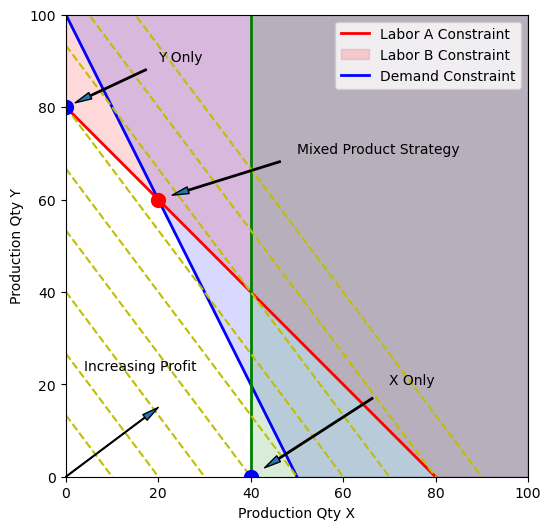

In [8]:
plt.figure(figsize=(6, 6))
plt.subplot(111, aspect='equal')
plt.axis([0, 100, 0, 100])
plt.xlabel('Production Qty X')
plt.ylabel('Production Qty Y')

# contrainte Labor A
x = np.array([0, 80])
y = 80 - x
plt.plot(x, y, 'r', lw=2)
plt.fill_between([0, 80, 100], [80, 0,0 ], [100, 100, 100], color='r', alpha=0.15)

# contrainte Labor B
x = np.array([0, 50])
y = 100 - 2*x
plt.plot(x, y, 'b', lw=2)
plt.fill_between([0, 50, 100], [100, 0, 0], [100, 100, 100], color='b', alpha=0.15)

# contrainte Demand
plt.plot([40, 40], [0, 100], 'g', lw=2)
plt.fill_between([40, 100], [0, 0], [100, 100], color='g', alpha=0.15)

plt.legend(['Labor A Constraint', 'Labor B Constraint', 'Demand Constraint'])

# contours du profit constant
x = np.array([0, 100])
for p in np.linspace(0, 3600, 10):
    y = (p - 40*x)/30
    plt.plot(x, y, 'y--')

# Optimum
plt.plot(20, 60, 'r.', ms=20)
plt.annotate('Mixed Product Strategy', xy=(20, 60), xytext=(50, 70), 
             arrowprops=dict(shrink=.1, width=1, headwidth=5))

plt.plot(0, 80, 'b.', ms=20)
plt.annotate('Y Only', xy=(0, 80), xytext=(20, 90), 
             arrowprops=dict(shrink=0.1, width=1, headwidth=5))

plt.plot(40, 0, 'b.', ms=20)
plt.annotate('X Only', xy=(40, 0), xytext=(70, 20), 
             arrowprops=dict(shrink=0.1, width=1, headwidth=5))

plt.text(4, 23, 'Increasing Profit')
plt.annotate('', xy=(20,15), xytext=(0,0), 
             arrowprops=dict(width=0.5,headwidth=5))

fname = 'LPprog01.png'
plt.savefig(fname, bbox_inches='tight')